In [101]:
import os
import cv2
import imghdr
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torchvision
from torch import nn

In [6]:
DATA_DIR = 'data'
IMG_EXT = ['png', 'jpg', 'jpeg', 'bmp']

In [7]:
# Data cleanup

In [9]:
for img_class in os.listdir(DATA_DIR):
    for image in os.listdir(os.path.join(DATA_DIR, img_class)):
        image_path = os.path.join(DATA_DIR, img_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in IMG_EXT:
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with {image_path}')

In [10]:
# Datasets

In [11]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((255, 255)),
                                            torchvision.transforms.ToTensor()])

In [12]:
data = torchvision.datasets.ImageFolder(DATA_DIR, transform=transform)

In [90]:
data.class_to_idx

{'family': 0, 'memes': 1}

In [13]:
# Dataloader

In [14]:
dataloader = torch.utils.data.DataLoader(dataset=data,
                                         batch_size=23,
                                         shuffle=True)

In [15]:
# x, y = next(iter(dataloader))

In [16]:
gen1 = torch.Generator().manual_seed(69)
train_set, test_set, val_set = torch.utils.data.random_split(dataloader, [0.7, 0.15, 0.15], generator=gen1)

In [17]:
print(len(train_set))
print(len(test_set))
print(len(val_set))

14
3
3


In [18]:
# x, y = next(a)

In [19]:
# x.shape, y.shape

In [77]:
class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2_block = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv3_block = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)
        
        self.dense_block = nn.Sequential(
            nn.Linear(16 * 30 * 30, 10),
            nn.ReLU()
        )
        
        self.output = nn.Sequential(
            nn.Linear(10, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x : torch.Tensor):
        batch_size = x.shape[0]
        x = self.conv1_block(x)
        x = self.conv2_block(x)
        x = self.conv3_block(x)
        x = self.flatten(x)
        x = self.dense_block(x)
        return self.output(x).reshape((batch_size))
        
        

In [21]:
model = Model()

In [22]:
 # Optimizer and loss
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

In [23]:
print(model)

Model(
  (conv1_block): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2_block): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3_block): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_block): Sequential(
    (0): Linear(in_features=14400, out_features=10, bias=True)
    (1): ReLU()
  )
  (output): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [24]:
# Train

In [27]:
def train_nn(epochs, net : torch.nn.Module, 
             train_set : torch.utils.data.DataLoader,
             val_set : torch.utils.data.DataLoader) -> (torch.nn.Module, list, list):
    
    net.train()                                              # Set the NN to training mode.
    
    epoch_count, train_loss_vals, val_loss_vals = [], [], [] # List that will be used to check model performance
    
    for epoch in range(1, epochs+1):
        for x_batch, y_batch in train_set.dataset:           # Joint the corresponding batches and unwrap them
            y_batch = y_batch.type(torch.float32)
            y_pred = net(x_batch)                            # Make predictions for the current batch
            loss = loss_fn(y_pred, y_batch)                  # Compute the loss of the predictions
            optimizer.zero_grad()                            # Reset the gradients
            loss.backward()                                  # Perform the backpropagation
            optimizer.step()                                 # Optimize the model
            
        for data, labels in val_set.dataset:
            labels = labels.type(torch.float32)
            preds = net(data)
            val_loss = loss_fn(preds, labels)
    
        # if epoch % 10 == 0:
        epoch_count.append(epoch)                            
        train_loss_vals.append(loss)
        val_loss_vals.append(val_loss)
        print(f"Epoch {epoch}: Train loss of {loss}; Validation loss of {val_loss}")
        # print(net.state_dict())                            # Bad idea, the state_dict is huge
            
    return net, epoch_count, train_loss_vals, val_loss_vals

In [28]:
trained_model, epoch_l, train_loss_l, val_loss_l = train_nn(40, model, train_set, val_set)

In [29]:
# Save

In [30]:
def save_model(model : nn.Module, file_name : str) -> None:
    MODEL_DIR = Path('MODELS')
    MODEL_NAME = f'{file_name}.pth'
    MODEL_PATH = MODEL_DIR / MODEL_NAME
    
    torch.save(obj=trained_model.state_dict(),
               f=MODEL_PATH)

In [ ]:
save_model(trained_model, 'trained_model_2')

In [341]:
# Plot the losses

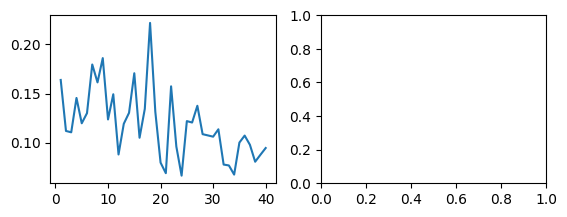

In [355]:
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
with torch.inference_mode():
    ax1.plot(epoch_l, train_loss_l)
    # ax2.plot(epoch_l, val_loss_l)   # Empty: forgot to add the append inside the train loop

In [46]:
def test_model(model : nn.Module):
    model.eval()
    with torch.inference_mode():
        for test_data, test_label in test_set.dataset:
            test_pred = model(test_data)
            test_loss = loss_fn(test_pred, test_label.type(torch.float32))
            print(test_loss)
    model.train()

In [31]:
# Load some model

In [79]:
def load_state_d(file_name : str) -> Model:
    MODEL_DIR = Path('MODELS')
    MODEL_NAME = f'{file_name}.pth'
    MODEL_PATH = MODEL_DIR / MODEL_NAME
    
    state_d = torch.load(MODEL_PATH)
    m = Model()
    m.load_state_dict(state_d)
    return m

In [80]:
loaded_model = load_state_d('trained_model_2')

In [81]:
# loaded_model.state_dict()

In [82]:
test_model(loaded_model)

tensor(0.0001)
tensor(9.4315e-05)
tensor(5.8615e-05)
tensor(5.1841e-05)
tensor(0.0001)
tensor(5.9789e-05)
tensor(6.2462e-05)
tensor(8.5722e-05)
tensor(2.2999e-05)
tensor(5.0157e-05)
tensor(3.0289e-05)
tensor(4.7441e-05)
tensor(3.2242e-05)
tensor(0.0001)
tensor(3.2469e-05)
tensor(0.0001)
tensor(0.0001)
tensor(0.0001)
tensor(0.0002)
tensor(0.0002)


In [83]:
# Test on a real image

In [84]:
TEST_IMGS = Path('TEST_IMGS')

In [85]:
img = Image.open(TEST_IMGS / 'nanny_test.jpg')

In [86]:
nanny_test = transform(img)
nanny_test = nanny_test[None, :]

In [87]:
pred = loaded_model(nanny_test)

In [88]:
pred

tensor([0.0006], grad_fn=<ReshapeAliasBackward0>)

In [91]:
# On a meme

In [93]:
img_meme = Image.open(TEST_IMGS / 'meme_1.png')

In [97]:
meme_test = transform(img_meme)
meme_test = meme_test[None, :]

In [99]:
pred2 = loaded_model(meme_test[:, :3, :, :])

In [100]:
pred2

tensor([1.], grad_fn=<ReshapeAliasBackward0>)